In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO, BytesIO
import zipfile
import requests

In [2]:
#Download zip
r = requests.get("https://snap.stanford.edu/data/twitch_gamers.zip")
archive = zipfile.ZipFile(BytesIO(r.content), 'r')

In [3]:
#Load rawdata

twitch_rawdata_edges = StringIO(str(archive.read('large_twitch_edges.csv'), 'utf-8'))
twitch_rawdata_feature = StringIO(str(archive.read('large_twitch_features.csv'), 'utf-8'))

twitch_raw_data_df_feature = pd.read_csv(twitch_rawdata_feature, sep=",")
twitch_raw_data_df_edges = pd.read_csv(twitch_rawdata_edges, sep=",")

In [4]:
#Get only polish streamers

twitch_filter_PL = twitch_raw_data_df_feature["language"] == "PL"
twitch_df_feature = twitch_raw_data_df_feature[twitch_filter_PL]

twitch_filter_edges = twitch_raw_data_df_edges["numeric_id_1"].isin(twitch_df_feature["numeric_id"])
twitch_filter_edges2 = twitch_raw_data_df_edges["numeric_id_2"].isin(twitch_df_feature["numeric_id"])
twitch_filter_edges_pair = twitch_filter_edges & twitch_filter_edges2
twitch_df_edges = twitch_raw_data_df_edges[twitch_filter_edges_pair]

In [5]:
#Create graph

twitch_graph = nx.from_pandas_edgelist(twitch_df_edges, 'numeric_id_1', 'numeric_id_2')

for index, node in twitch_df_feature.iterrows():
    twitch_graph.add_node(node["numeric_id"], 
                          views=node["views"],
                          mature=node["mature"],
                          life_time=node["life_time"],
                          created_at=node["created_at"],
                          updated_at=node["updated_at"],
                          dead_account=node["dead_account"],
                          language=node["language"],
                          affiliate=node["affiliate"])

In [6]:
degree_sequence = sorted((d for n, d in twitch_graph.degree()), reverse=True)

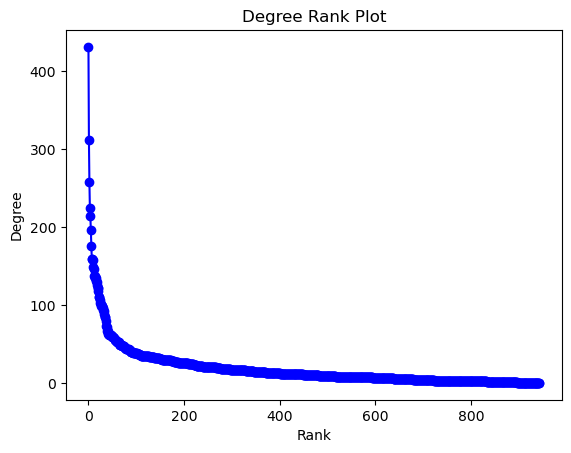

In [7]:
plt.plot(degree_sequence, "b-", marker="o")
plt.title("Degree Rank Plot")
plt.xlabel("Rank")
plt.ylabel("Degree")
plt.show()

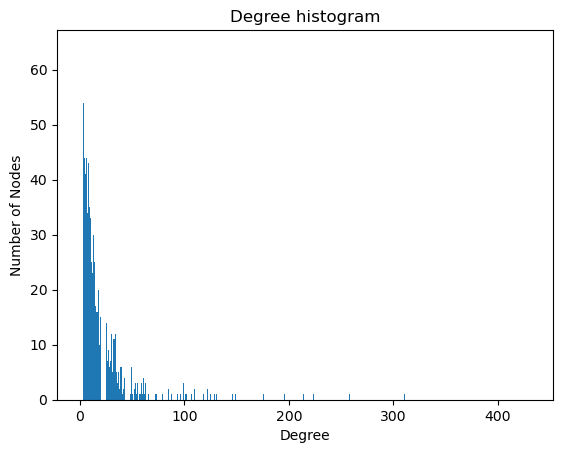

In [8]:
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()

In [76]:
p = dict(nx.shortest_path_length(twitch_graph))
p_df = pd.json_normalize(p, sep='_')
p_flat = p_df.to_dict(orient='records')[0]

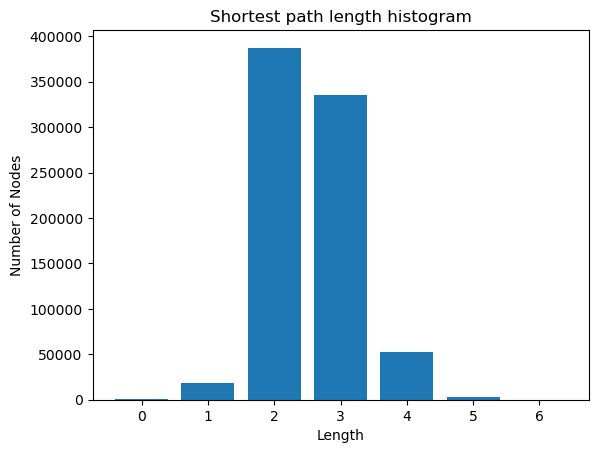

In [74]:
plt.bar(*np.unique(list(p_flat.values()), return_counts=True))
plt.title("Shortest path length histogram")
plt.xlabel("Length")
plt.ylabel("Number of Paths")
plt.show()

In [84]:
centr = nx.betweenness_centrality(twitch_graph)

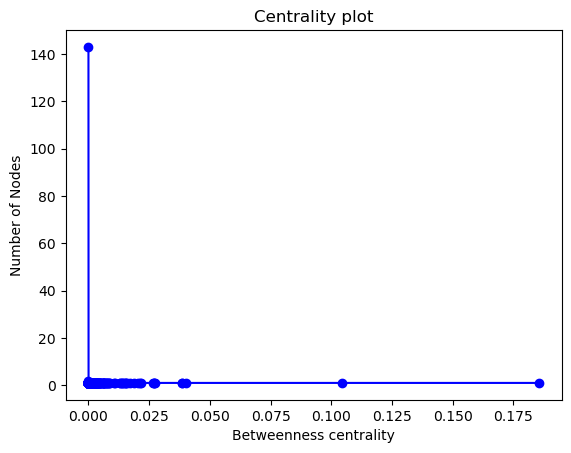

In [98]:
#plt.bar(*np.unique(list(centr.values()), return_counts=True))
plt.plot(*np.unique(list(centr.values()), return_counts=True), "b-", marker="o")
plt.title("Centrality plot")
plt.xlabel("Betweenness centrality")
plt.ylabel("Number of Nodes")
plt.show()

In [102]:
clusters = nx.clustering(twitch_graph)

{96766: 0.3439153439153439,
 35406: 0.19900990099009902,
 84957: 0.17974806201550386,
 52552: 0.038925160524469864,
 139942: 0.10688311688311689,
 62533: 0.13568521031207598,
 166238: 0.1,
 69297: 0.04729799813297376,
 145379: 0.16750700280112044,
 55574: 0.11900601824888371,
 40570: 0.04443967367969085,
 27505: 0.13535483870967743,
 36204: 0.1620217288615966,
 28827: 0.19838056680161945,
 25289: 0.07923868126564715,
 127211: 0.09948979591836735,
 104806: 0.09533151825752723,
 54475: 0.15262718932443703,
 87730: 0.2,
 40347: 0.0455820476858345,
 160994: 0.054945054945054944,
 141546: 0.058823529411764705,
 134338: 0.09650064405324174,
 142214: 0.0392156862745098,
 88326: 0.09532015236713223,
 26508: 0.11849920324496596,
 49188: 0.17424242424242425,
 68395: 0.10255583326614529,
 60368: 0.10714285714285714,
 26184: 0.38461538461538464,
 31196: 0.20320855614973263,
 115873: 0.2350230414746544,
 109266: 0.09147360878910915,
 142603: 0.1551912568306011,
 128276: 0.0692402648412075,
 8447: 0

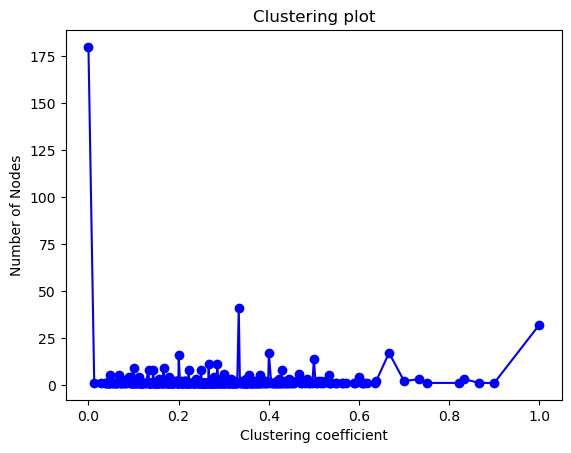

In [110]:
#plt.bar(*np.unique(list(clusters.values()), return_counts=True))
plt.plot(*np.unique(list(clusters.values()), return_counts=True), "b-", marker="o")
plt.title("Clustering plot")
plt.xlabel("Clustering coefficient")
plt.ylabel("Number of Nodes")
plt.show()

In [116]:
dens = nx.density(twitch_graph)
dens

#współczynnik centralizacji = suma wszystkich centralności/liczba wierzchołków?

#graf jest rozłączny D: (można podzielić graf na podgrafy i na tym zrobić radius)
#radius = nx.radius(twitch_graph)
#radius

{96766: 0.439915650913321,
 35406: 0.4697985626123328,
 84957: 0.4826992096405891,
 52552: 0.5984100840083332,
 139942: 0.4954540331484144,
 62533: 0.4311488086110116,
 166238: 0.3182792223507166,
 69297: 0.5521977869448623,
 145379: 0.4412961393576097,
 55574: 0.4320318578862006,
 40570: 0.4558391239609669,
 27505: 0.47562470036738996,
 36204: 0.4914142215793534,
 28827: 0.4340320053764145,
 25289: 0.5240734276097824,
 127211: 0.39354394517339075,
 104806: 0.5205170996000924,
 54475: 0.4580663509510042,
 87730: 0.32869428065903766,
 40347: 0.44714267008571795,
 160994: 0.3692596142020787,
 141546: 0.3792171768322471,
 134338: 0.4669386931110956,
 142214: 0.41018873040921233,
 88326: 0.4630945216529911,
 26508: 0.47216464378945144,
 49188: 0.41421611116924384,
 68395: 0.47508908696607527,
 60368: 0.33429406436281683,
 26184: 0.4012164614606513,
 31196: 0.41915460429793827,
 115873: 0.42765241685339567,
 109266: 0.4682343054671197,
 142603: 0.41749540744767427,
 128276: 0.46849429120030

In [118]:
communities = nx.algorithms.community.greedy_modularity_communities(twitch_graph, weight='weight')

In [120]:
colors = range(len(communities))

node_color_map = {}
for i, community in enumerate(communities):
    for node in community:
        node_color_map[node] = colors[i]

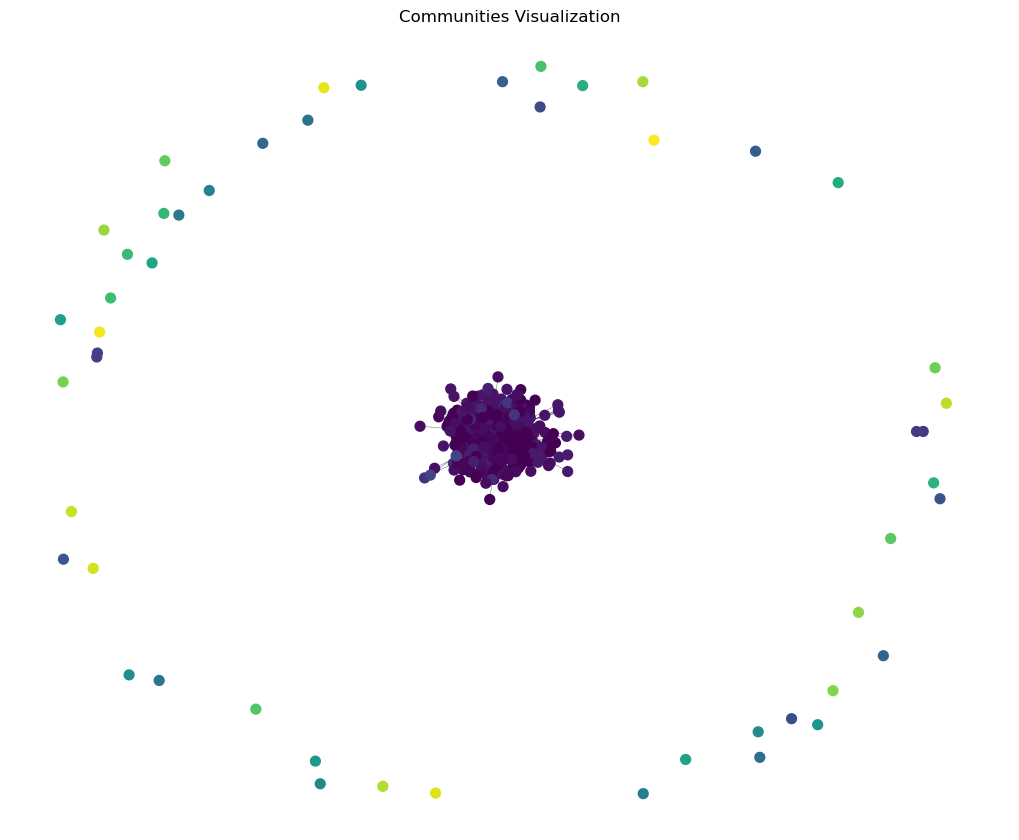

In [126]:
plt.figure(figsize=(10, 8))
pos = nx.layout.spring_layout(twitch_graph)
nx.draw(
    twitch_graph, 
    pos, 
    node_color=[node_color_map[node] for node in twitch_graph.nodes()], 
    with_labels=False, 
    node_size=50,
    width=0.2
)
plt.title('Communities Visualization')
plt.show()